This notebook shows the code and use of PDF.py and the class PDF

# Code

In [ ]:
# %load ../Tools/PDF.py
import scipy.interpolate as spip
from copy import deepcopy


class PDF():
    '''
    Class to deal with spectrum and build a PDF interpolating an histogram
    '''

    def __init__(self, histogram=[], factor=1., name='default',
                 isotope='default', volume='default', material='default',
                 interpolation='linear', labelcopy=False):
        '''
        histogram: hist to build the PDF from
        factor: factor to scale the PDF
        name: name for the PDF
        isotope, volume, material: info about PDF and hist data
        interpolation: interpolation method, as in scipy.interpolate.interp1d:
            Specifies the kind of interpolation as a string (‘linear’,
            ‘nearest’, ‘zero’, ‘slinear’, ‘quadratic, ‘cubic’ where ‘slinear’,
            ‘quadratic’ and ‘cubic’ refer to a spline interpolation of first,
            second or third order) or as an integer specifying the order of the
            spline interpolator to use. Default is ‘linear’.
        labelcopy: if True, the isotope, volume and material info is copied
            from hist one
        '''
        if not labelcopy:
            self.name = name
            self.isotope = isotope
            self.volume = volume
            self.material = material
        else:
            self.name = histogram.name
            self.isotope = histogram.isotope
            self.volume = histogram.volume
            self.material = histogram.material

        self.Int = factor
        self.minlim = 0
        self.maxlim = 0
        self.pdf = spip.interp1d
        self.interpolation = interpolation
        if histogram:
            self.Build_PDF(deepcopy(histogram), factor)

    def Build_PDF(self, hist, factor):
        '''
        It builds the pdf from the histogram normalazing
        that is that the integral (number of events) is
        one
        '''

        hist.Scale(float(factor)/(hist.hist.sum()))  # *hist.binsize)
        self.pdf = spip.interp1d(hist.bins, hist.hist,
                                 kind=self.interpolation, bounds_error=False)
        self.minlim = hist.bins[0]
        self.maxlim = hist.bins[-1]
        self.Int = self.pdf.y.sum()*(self.pdf.x[1]-self.pdf.x[0])

        return

    def Scale(self, factor):
        '''
        Method to scale the pdf. It also refresh the integral
        counter
        '''
        x = self.pdf.x
        y = factor*self.pdf.y
        self.pdf = spip.interp1d(x, y, kind=self.interpolation,
                                 bounds_error=False)
        self.Int *= factor
        return self


# Using code

In [5]:
import scipy as sp
import scipy.interpolate as spip
import scipy.integrate as spin
import matplotlib.pylab as plt
import numpy as np
%matplotlib inline

from Histogram import Histogram

In [13]:
#Creating histogram from a gaussian vector, mean 5 sigma 2
auxlist = np.random.normal(5,2,10000000)   
a = Histogram(auxlist,100,0,10)

In [14]:
#Creating PDF
b = PDF(a,interpolation='linear')

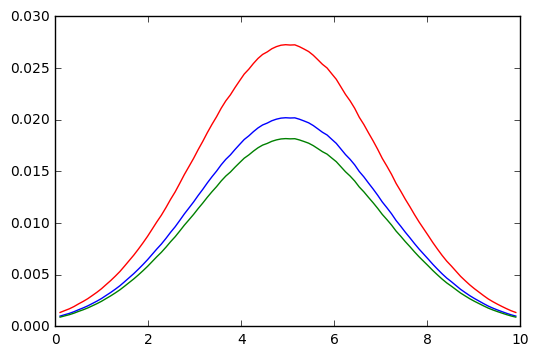

In [9]:
#Plotting and scaling PDF
x = np.linspace(0.1,9.9,100)
y = b.pdf(x)
yp = (b.Scale(0.9)).pdf(x)
ypp = (b.Scale(1.5)).pdf(x)
plt.plot(x,y)
plt.plot(x,yp)
plt.plot(x,ypp)


# Aplication to Spectrum Data

In [16]:
#reading data
import tables as tb
f = tb.open_file("../Data/data_spectrum.h5", "r")
E = f.root.E[:]
Co = f.root.Co[:]

In [17]:
#Creating hist from empty initialization adn pdf from hist
minE,maxE,nbin = 0.,3.,125 #Just for initialization, not used
h_Co = Histogram([],nbin,minE,maxE)
h_Co.hist = Co
h_Co.bins = E
pdf_Co = PDF(h_Co,1.,interpolation='linear')

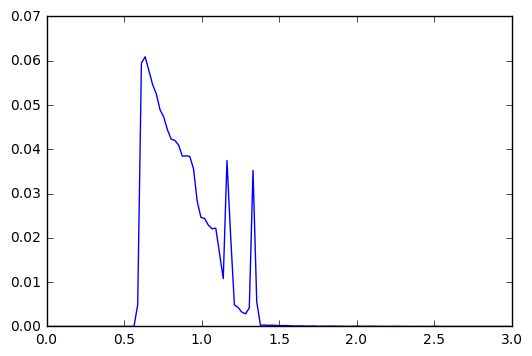

In [42]:
plt.plot(E,pdf_Co.pdf.y)

In [46]:
pdf_Co.Int

0.024000000000000004

In [45]:
sp.integrate.quad(pdf_Co.pdf,pdf_Co.minlim,pdf_Co.maxlim)

/home/brais/anaconda3/lib/python3.5/site-packages/scipy/integrate/quadpack.py:356: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)


(0.02399989298564686, 0.0001089529133330748)